##  ewf-ext-02-03-01 - Landsat-7 and -8 NDVI time series

Landsat-7 and -8 NDVI time series

### <a name="service">Service Definition

In [1]:
service = dict([('title', 'Landsat-7 and -8 NDVI time series'),
                ('abstract', 'Landsat-7 and -8 NDVI time series'),
                ('id', 'ewf-ext-02-03-01')])

### <a name="parameter">Parameter Definition 

**AOI**

AOI

In [2]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                         ('value', 'POLYGON ((-8.864205 38.88616500000001, -8.864205 38.986165, -8.964205000000002 38.986165, -8.964205000000002 38.88616500000001, -8.864205 38.88616500000001))'),
                         ('title', 'WKT Polygon for the Region of Interest'),
                         ('abstract', 'Set the value of WKT Polygon')])

**Name of AOI**

Name of AOI

In [3]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'Leziria'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifier**

This is the Sentinel-2 product identifier

In [4]:
# landsat-7
input_identifier = 'LE07_L1TP_204033_20171130_20171226_01_T1'
input_identifier = 'LE07_L1TP_204033_20171114_20171210_01_T1'
input_identifier = 'LE07_L1TP_204033_20170927_20171023_01_T1'
input_identifier = 'LE07_L1TP_204033_20170911_20171007_01_T1'

# landsat-8
#input_identifier = 'LC08_L1TP_204033_20190723_20190801_01_T1'

**Input reference**

This is the Sentinel-2 catalogue reference

In [5]:
# landsat-7
input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20171130_20171226_01_T1'
input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20171114_20171210_01_T1'
input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20170927_20171023_01_T1'
input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20170911_20171007_01_T1'
#input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20170810_20170905_01_T1'
#input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20170725_20170820_01_T1'

# landsat-8
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190723_20190801_01_T1'

**Data path**

This path defines where the data is staged-in. 

In [6]:
data_path = '/workspace/data/Landsat-7/ftp.deimos.com.pt/Landsat_7_ETM+_C1_Level-2_3ys'
data_path = '/workspace/data/Landsat-7/staged-in'

###  Aux folders

In [7]:
output_folder = ''

In [8]:
temp_folder = 'temp'

### <a name="workflow">Workflow

#### Import Modules

In [9]:
import os
import sys

from urlparse import urlparse

from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.wkt import loads
from shapely.geometry import box
import cioppy
import lxml.etree as etree
#import gdal
#import osr

#import numpy as np
from osgeo import gdal, ogr, osr

import numpy as np
from geopandas import GeoDataFrame
import pandas as pd
import geopandas as gp

import glob

import datetime


ciop = cioppy.Cioppy()

###  Auxiliary vars

In [10]:
check_results = True
export_properties_file = True

###  Auxiliary methods

In [11]:
 # remove contents of a given folder
# used to clean a temporary folder
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

###   Auxiliary folders

In [12]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)
    
    
    
def eop_metadata(metadata):

    opt = 'http://www.opengis.net/opt/2.1'
    om  = 'http://www.opengis.net/om/2.0'
    gml = 'http://www.opengis.net/gml/3.2'
    eop = 'http://www.opengis.net/eop/2.1'
    sar = 'http://www.opengis.net/sar/2.1'
    
    root = etree.Element('{%s}EarthObservation' % opt)

    phenomenon_time = etree.SubElement(root, '{%s}phenomenonTime' % om)

    time_period = etree.SubElement(phenomenon_time, '{%s}TimePeriod' % gml)

    begin_position = etree.SubElement(time_period, '{%s}beginPosition'  % gml)

    end_position = etree.SubElement(time_period, '{%s}endPosition'  % gml)

    procedure = etree.SubElement(root, '{%s}procedure' % om)

    earth_observation_equipment = etree.SubElement(procedure, '{%s}EarthObservationEquipment' % eop)

    acquisition_parameters = etree.SubElement(earth_observation_equipment, '{%s}acquisitionParameters' % eop)

    acquisition = etree.SubElement(acquisition_parameters, '{%s}Acquisition' % sar)

    orbit_number = etree.SubElement(acquisition, '{%s}orbitNumber' % eop)

    wrs_longitude_grid = etree.SubElement(acquisition, '{%s}wrsLongitudeGrid' % eop)

    wrs_latitude_grid = etree.SubElement(acquisition, '{%s}wrsLatitudeGrid' % eop)
    
    
    feature_of_interest = etree.SubElement(root, '{%s}featureOfInterest' % om)
    footprint = etree.SubElement(feature_of_interest, '{%s}Footprint' % eop)
    multi_extentOf = etree.SubElement(footprint, '{%s}multiExtentOf' % eop)
    multi_surface = etree.SubElement(multi_extentOf, '{%s}MultiSurface' % gml)
    surface_members = etree.SubElement(multi_surface, '{%s}surfaceMembers' % gml)
    polygon = etree.SubElement(surface_members, '{%s}Polygon' % gml)    
    exterior = etree.SubElement(polygon, '{%s}exterior' % gml)  
    linear_ring = etree.SubElement(exterior, '{%s}LinearRing' % gml) 
    poslist = etree.SubElement(linear_ring, '{%s}posList' % gml) 


    result = etree.SubElement(root, '{%s}result' % om)
    earth_observation_result = etree.SubElement(result, '{%s}EarthObservationResult' % opt)
    cloud_cover_percentage = etree.SubElement(earth_observation_result, '{%s}cloudCoverPercentage' % opt)
    
    metadata_property = etree.SubElement(root, '{%s}metaDataProperty' % eop)
    earth_observation_metadata = etree.SubElement(metadata_property, '{%s}EarthObservationMetaData' % eop)
    identifier = etree.SubElement(earth_observation_metadata, '{%s}identifier' % eop)
    
    begin_position.text = metadata['startdate']
    end_position.text = metadata['enddate']
    orbit_number.text = metadata['orbitNumber']
    wrs_longitude_grid.text = metadata['wrsLongitudeGrid']
    wrs_latitude_grid.text = metadata['wrsLatitudeGrid']
    
    coords = np.asarray([t[::-1] for t in list(loads(metadata['wkt']).exterior.coords)]).tolist()
 
    pos_list = ''
    for elem in coords:
        pos_list += ' '.join(str(e) for e in elem) + ' '   

    poslist.attrib['count'] = str(len(coords))
    poslist.text = pos_list
    
    
    identifier.text = metadata['identifier']

    return etree.tostring(root, pretty_print=True)



#
# crop landsat 7 given bands
#
def get_bands_geotiff_ls7(product_name, band_indices, crop=False, bbox=None):
    
    
    
    
    output = '/vsimem/clip.tif'
    
    #parsed_url = urlparse(download_url)
    #url = '%s://%s/api%s' % (list(parsed_url)[0], list(parsed_url)[1], list(parsed_url)[2])
    
    #gdal.UseExceptions()
    #gdal.SetConfigOption("GDAL_DISABLE_READDIR_ON_OPEN","YES")
    #gdal.SetConfigOption("CPL_VSIL_CURL_ALLOWED_EXTENSIONS","tif")
    
    try:
        
        print('GDAL is opening:')
        print(product_name)
        
        ds = gdal.Open(product_name)
        
    except Exception as e:
        print e
        raise
        
    if crop == True:
        print 'Cropping data...'
        ulx, uly, lrx, lry = bbox[0], bbox[3], bbox[2], bbox[1]
        ds = gdal.Translate(output, ds, bandList=band_indices, projWin = [ulx, uly, lrx, lry], projWinSRS = 'EPSG:4326')
        print 'data cropping : DONE'
        
    else:    
        ds = gdal.Translate(output, ds, bandList=band_indices)
        
    ds = None
    ds = gdal.Open(output)
    w = ds.GetRasterBand(1).XSize
    h = ds.GetRasterBand(1).YSize
    geo_transform = ds.GetGeoTransform()
    projection = ds.GetProjection()

    for i,b in enumerate(band_indices):
        
        out_name = '%s_SR_B%s.TIF' % (ls_catalogue_metadata['identifier'], str(b))
        
        #out_name = '/'.join([temp_folder, out_name])
        out_name = os.path.join(temp_folder, out_name)
        
        print 'creating %s' %out_name
        
        data = ds.GetRasterBand(i+1).ReadAsArray(0, 0, w, h).astype(np.float32)
        
        bmin = data[data!=-9999].min()
        bmax = data[data!=-9999].max()
        #Let's map the data into [0.0, 1.0]
        if bmin != bmax:
            data[data!= -9999] = (data[data!=-9999] - bmin)/(bmax - bmin)
        else:
            data[data!=-9999] = 1.0
        

    
        drv = gdal.GetDriverByName('GTiff')

        ds2 = drv.Create(out_name, w, h, 1, gdal.GDT_Float32)

        ds2.SetGeoTransform(geo_transform)
        ds2.SetProjection(projection)

        ds2.GetRasterBand(1).WriteArray(data, 0, 0)
        ds2.FlushCache()

    
    ds = None
    ds2=None
    
    return


        
#
# crop landsat 8 given bands
#
def get_bands_geotiff_ls8(product_path_folder, product_identifier, band_indices, crop=False, bbox=None):
    
    # comeca aqui
    #url = 'https://store.terradue.com/download/landsat8/files/v1/LC08_L1TP_204033_20190723_20190801_01_T1'

    
    
    # get identifier
    l8identifier = product_identifier
    
    # get band names
    band_names = []
    
    for i in band_indices:
        
        if isinstance(i, str):
            band_names.append(l8identifier + '_B{0}.TIF'.format(i))
        else:
            band_names.append(l8identifier + '_B{0}.TIF'.format(i))
        

    #file_path = product_name
    
    
    
    # get product file path
    if product_path_folder[-1] == '/':
        file_path = glob.glob(product_path_folder + '*.tar')
    else:
        file_path = glob.glob(product_path_folder + '/*.tar')

    file_path = file_path[0]
    
    print(file_path)
    
    
    #print(file_path)
    
    
    
    # open each band image
       
    for bname in band_names:
        
        try:
            print('GDAL is opening:')
        
            print('/vsitar/{0}/{1}'.format(file_path, bname))
        
            ds = gdal.Open('/vsitar/{0}/{1}'.format(file_path, bname))
        
            #ds3 = gdal.Open('/vsitar/%s/LC08_L1TP_204033_20190723_20190801_01_T1_B3.TIF' % file_path)
        
        except Exception as e:
            print e
            raise
        
    

        # crop it
    
        output = temp_folder + '/clip.tif'
    
        if crop == True:
            print 'Cropping data...'
            ulx, uly, lrx, lry = bbox[0], bbox[3], bbox[2], bbox[1]
            ds = gdal.Translate(output, ds, projWin = [ulx, uly, lrx, lry], projWinSRS = 'EPSG:4326')
            print 'data cropping : DONE'
        
        else:
            ds = gdal.Translate(output, ds)
        
    
    
        ds = None
        ds = gdal.Open(output)
        w = ds.GetRasterBand(1).XSize
        h = ds.GetRasterBand(1).YSize
        geo_transform = ds.GetGeoTransform()
        projection = ds.GetProjection()
    
    
        out_name = bname
        
        #out_name = '/'.join([temp_folder, out_name])
        out_name = os.path.join(temp_folder, out_name)
        
        print 'creating %s' %out_name
        
        data = ds.GetRasterBand(1).ReadAsArray(0, 0, w, h).astype(np.float32)
        
        if '_BQA.TIF' in bname:
            pass
        else:
            bmin = data[data!=-9999].min()
            bmax = data[data!=-9999].max()
            #Let's map the data into [0.0, 1.0]
            if bmin != bmax:
                data[data!= -9999] = (data[data!=-9999] - bmin)/(bmax - bmin)
            else:
                data[data!=-9999] = 1.0
            

    
        drv = gdal.GetDriverByName('GTiff')

        ds2 = drv.Create(out_name, w, h, 1, gdal.GDT_Float32)

        ds2.SetGeoTransform(geo_transform)
        ds2.SetProjection(projection)

        ds2.GetRasterBand(1).WriteArray(data, 0, 0)
        ds2.FlushCache()

    
        ds = None
        ds2 = None
        

        
        

#
# Computes ndvi image
# and saves it in geotif
#
def get_cloud_mask(band_qa):
    
    print('GENERATING MASK from: {0}'.format(band_qa))
    
    mat_band_qa = load_img_to_matrix(band_qa)
    
    cloud_mask = np.full_like(mat_band_qa, 0)
    
    # 1st row - clouds
    # 2nd row - Cloud shadow - high
    # codes from here: https://www.usgs.gov/media/images/landsat-8-quality-assessment-band-attributes-and-possible-values
    # and from here: LSDS-1370_L4-7_SurfaceReflectance-LEDAPS_ProductGuide-v2.pdf
    if 'LC08_' in band_qa:
        pixel_values_to_mask = [2800, 2804, 2808, 2812, 6896, 6900, 6904, 6908,
                                2976, 2980, 2984, 2988, 3008, 3012, 3016, 3020, 7072, 7076, 7080, 7084, 7104, 7108, 7112, 7116]
    else:
        pixel_values_to_mask = [96, 112, 160, 176, 224,
                                72, 136]
    
    for pv in pixel_values_to_mask:
        cloud_mask[mat_band_qa == pv] = -9999
    
    return cloud_mask
        
        

def get_wkt(geotiff):

    src = gdal.Open(geotiff)
    
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()

    max_x = ulx + (src.RasterXSize * xres)
    min_y = uly + (src.RasterYSize * yres)
    min_x = ulx 
    max_y = uly
    
    source = osr.SpatialReference()
    
    source.ImportFromWkt(src.GetProjection())

    target = osr.SpatialReference()
    target.ImportFromEPSG(4326)

    transform = osr.CoordinateTransformation(source, target)

    a = transform.TransformPoint(min_x, min_y)
    
    wkt_out = box(transform.TransformPoint(min_x, min_y)[0],
                    transform.TransformPoint(min_x, min_y)[1],
                    transform.TransformPoint(max_x, max_y)[0],
                    transform.TransformPoint(max_x, max_y)[1]).wkt
    
    
    return wkt_out

#
# ndvi computation
#
# Input:
# NIR - spectral reflectance measurement acquired in the red (visible) region
# red - spectral reflectance measurement acquired in the near-infrared region
# 
# Output:
# ndvi -  normalized difference vegetation index
#
def get_ndvi (nir, red):
    
    ndvi = -9999
    
    if nir >= 0 and nir <= 1 and red >= 0 and red <= 1:
        ndvi = ( nir - red ) / ( nir + red )
    
    return ndvi


def load_img_to_matrix (img_path):
    
    dataset = gdal.Open(img_path)
    product_array = dataset.GetRasterBand(1).ReadAsArray()
    return product_array


def get_metadata(filepath):
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type



def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    
    
    if mask is not None and mask is not 0:
        # TODO: check if output folder exists
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)
    


#
# Computes ndvi image
# and saves it in geotif
#
def normalized_difference(band_1, band_2, metadata, output_name, mask_clouds = False, band_3 = None):

    metadata_name = '{0}.xml'.format(output_name)
    
    #otb_app = otbApplication.Registry.CreateApplication('BandMath')
    
    #otb_app.SetParameterStringList('il', [band_1, band_2])

    #otb_app.SetParameterString('out', '{0}.TIF'.format(output_name))
    
    #otb_app.SetParameterString('exp', 'im1b1 >= 0 && im1b1 <= 1 && im2b1 >= 0 && im2b1 <= 1 ? ( im1b1 - im2b1 ) / ( im1b1 + im2b1 ) : -9999 ')

    #otb_app.ExecuteAndWriteOutput()
    
    
    mat_band_1 = load_img_to_matrix(band_1)
    mat_band_2 = load_img_to_matrix(band_2)
    
    
    ndvi_calculator = np.vectorize(get_ndvi)
    
    mat_ndvi = ndvi_calculator(mat_band_1, mat_band_2)
    
    if mask_clouds: # mask clouds and cloud shadows
        
        cloud_mask = get_cloud_mask(band_3)
        
        mat_ndvi[cloud_mask == -9999] = -9999
        
    
    projection, geotransform, no_data_value, data_type = get_metadata(band_1)
    
    no_data_value = -9999

    write_output_image(output_name + '.TIF', mat_ndvi, 'GTiff', data_type, None, projection, geotransform, no_data_value)
    
    
    #Set the actual wkt for NDVI 
    metadata['wkt'] = get_wkt('{0}.TIF'.format(output_name))
    
    metadata['identifier'] = output_name
    
    return True


def get_formatted_date(datetime_str):
    date = datetime.datetime.strftime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    #first_date = get_formatted_date(first_date)
    #last_date = get_formatted_date(last_date)
    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date, last_date))
        file.write('geometry=%s' % (region_of_interest))

### Define the AOI

In [13]:
aoi_wkt = loads(regionOfInterest['value'])
aoi_wkt.wkt

'POLYGON ((-8.864205 38.88616500000001, -8.864205 38.986165, -8.964205000000002 38.986165, -8.964205000000002 38.88616500000001, -8.864205 38.88616500000001))'

In [14]:
bbox = list(aoi_wkt.bounds)
bbox

[-8.964205000000002, 38.88616500000001, -8.864205, 38.986165]

#### Get the metadata of the Landsat product

In [15]:
#ciop = cioppy.Cioppy()

temp_results = []

search_params = dict()

search_params['do'] = 'terradue'

ls_catalogue_metadata = ciop.search(end_point=input_reference,
                                     params=[],
                                     output_fields='enclosure,identifier,startdate,enddate,wkt,orbitNumber,swathIdentifier,wrsLongitudeGrid,wrsLatitudeGrid',
                                     model='EOP')[0]


In [16]:
ls_catalogue_metadata

{'enclosure': 'https://store.terradue.com/espa-sr/2017/09/11/files/v1/LE07_L1TP_204033_20170911_20171007_01_T1_SR.tif',
 'enddate': '2017-09-11T11:17:20.1980000Z',
 'identifier': 'LE07_L1TP_204033_20170911_20171007_01_T1',
 'orbitNumber': '',
 'startdate': '2017-09-11T11:16:53.4440000Z',
 'swathIdentifier': '',
 'wkt': 'POLYGON((-10.2146 38.25085,-8.06958 37.93939,-7.55422 39.53579,-9.7472 39.85433,-10.2146 38.25085))',
 'wrsLatitudeGrid': '',
 'wrsLongitudeGrid': ''}

#### check if it is landsat 7 or 8 

In [17]:
# 'LE07' - Landsat 7
# 'LC08' - Landsat 8
lscode = ls_catalogue_metadata['identifier'][0:4]

if lscode == 'LC08':
    print('Landsat 8')
else:
    print('Landsat 7')

Landsat 7


#### crop nir and red bands from LS product

In [18]:
band_1 = 4
band_2 = 3
band_3 = 8

if lscode == 'LC08':
    band_1 = 5
    band_2 = 4
    band_3 = 'QA'

band_1_name = '%s_SR_B%s.TIF' % (ls_catalogue_metadata['identifier'], str(band_1))
band_2_name = '%s_SR_B%s.TIF' % (ls_catalogue_metadata['identifier'], str(band_2))
band_3_name = '%s_SR_B%s.TIF' % (ls_catalogue_metadata['identifier'], str(band_3))

# landsat 8
if lscode == 'LC08':
    band_1_name = ls_catalogue_metadata['identifier'] + '_B{0}.TIF'.format(band_1)
    band_2_name = ls_catalogue_metadata['identifier'] + '_B{0}.TIF'.format(band_2)
    band_3_name = ls_catalogue_metadata['identifier'] + '_B{0}.TIF'.format(band_3)



#band_1_name = '/'.join([temp_folder, band_1_name])
#band_2_name = '/'.join([temp_folder, band_2_name])

band_1_name = os.path.join(temp_folder, band_1_name)
band_2_name = os.path.join(temp_folder, band_2_name)
band_3_name = os.path.join(temp_folder, band_3_name) # QA band


print(band_1_name)
print(band_2_name)
print(band_3_name)


ciop.log("INFO", "Getting and cropping Landsat bands")



if lscode == 'LC08':
    
    #head, tail = os.path.split(ls_catalogue_metadata['enclosure'])
    
    #ls8_product_path = os.path.join(data_path, tail) + '.tar'
    
    get_bands_geotiff_ls8(data_path, ls_catalogue_metadata['identifier'], [band_2,band_1,band_3], crop=True, bbox=bbox)
else:
    head, tail = os.path.split(ls_catalogue_metadata['enclosure'])
    
    ls7_product_path = os.path.join(data_path, tail)
    
    get_bands_geotiff_ls7(ls7_product_path, [band_2,band_1,band_3], crop=True, bbox=bbox)
    

temp/LE07_L1TP_204033_20170911_20171007_01_T1_SR_B4.TIF
temp/LE07_L1TP_204033_20170911_20171007_01_T1_SR_B3.TIF
temp/LE07_L1TP_204033_20170911_20171007_01_T1_SR_B8.TIF
GDAL is opening:
/workspace/data/Landsat-7/staged-in/LE07_L1TP_204033_20170911_20171007_01_T1_SR.tif
Cropping data...
data cropping : DONE
creating temp/LE07_L1TP_204033_20170911_20171007_01_T1_SR_B3.TIF
creating temp/LE07_L1TP_204033_20170911_20171007_01_T1_SR_B4.TIF
creating temp/LE07_L1TP_204033_20170911_20171007_01_T1_SR_B8.TIF


reporter:status:2019-09-24T12:53:08.000264 [INFO   ] [user process] Getting and cropping Landsat bands
2019-09-24T12:53:08.000264 [INFO   ] [user process] Getting and cropping Landsat bands


#### Compute NDVI

In [19]:
output_name = '{0}_SR_{1}'.format(ls_catalogue_metadata['identifier'],'NDVI')

print(ls_catalogue_metadata['identifier'])

ciop.log("INFO", "Computing NDVI")

normalized_difference(band_1_name,
                      band_2_name,
                      ls_catalogue_metadata,
                      output_name,
                      mask_clouds = True,
                      band_3 = band_3_name)

new_identifier = ls_catalogue_metadata['identifier']
metadata_name = '{0}.xml'.format(new_identifier)

with open(metadata_name, 'wb') as file:
    file.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    file.write(eop_metadata(ls_catalogue_metadata))


LE07_L1TP_204033_20170911_20171007_01_T1


reporter:status:2019-09-24T12:53:08.187798 [INFO   ] [user process] Computing NDVI
2019-09-24T12:53:08.187798 [INFO   ] [user process] Computing NDVI


GENERATING MASK from: temp/LE07_L1TP_204033_20170911_20171007_01_T1_SR_B8.TIF


In [20]:
output_name

'LE07_L1TP_204033_20170911_20171007_01_T1_SR_NDVI'

## Check results

In [21]:
if check_results:
    import matplotlib
    import matplotlib.pyplot as plt
    from PIL import Image
    %matplotlib inline


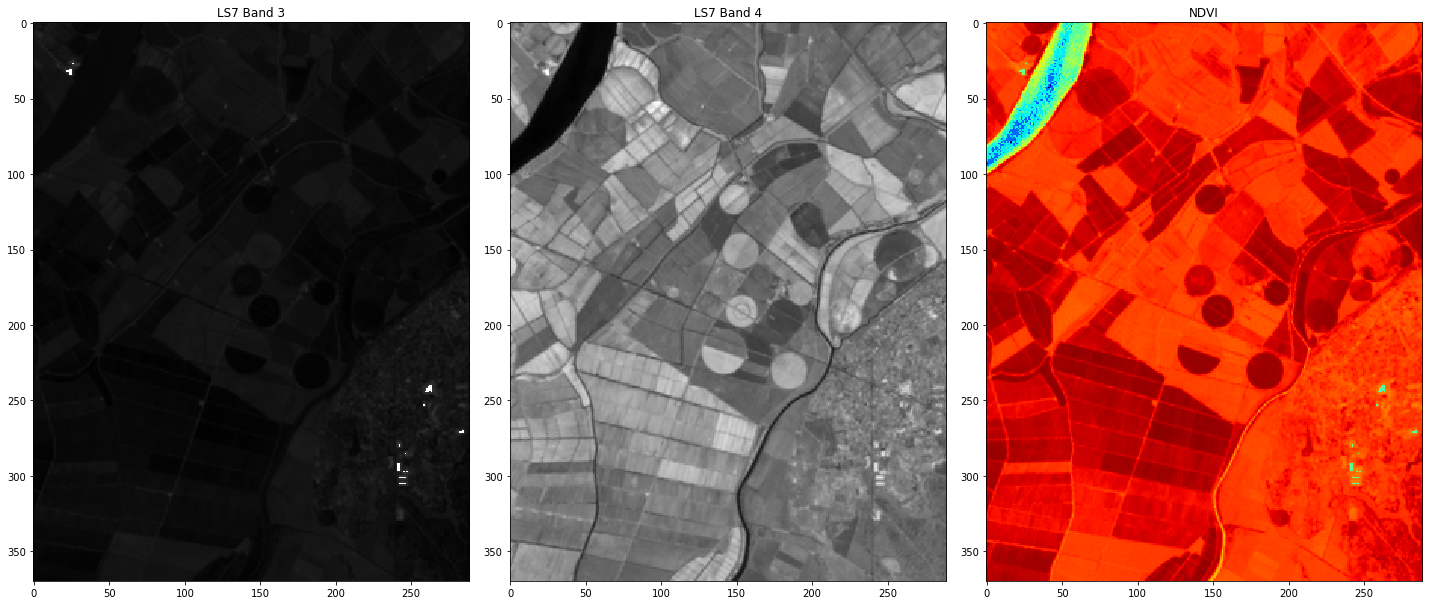

In [22]:
if check_results:
    
    ds = gdal.Open(band_1_name)
    band4 = ds.GetRasterBand(1).ReadAsArray()
    ds=None

    ds = gdal.Open(band_2_name)
    band3 = ds.GetRasterBand(1).ReadAsArray()
    ds=None

    ds = gdal.Open('{0}.TIF'.format(output_name))
    ndvi = ds.GetRasterBand(1).ReadAsArray()
    ds=None

    for b in [band3, band4, ndvi]:

        bmin = b[b!=-9999].min()
        bmax =  b[b!=-9999].max()
        
        if bmin != bmax:    
            b[b!=-9999] = (b[b!=-9999] - bmin)/(bmax - bmin) * 255
  
        b[b==-9999]=np.nan

    fig = plt.figure(figsize=(20,20))

    a = fig.add_subplot(1,3,1)
    imgplot = plt.imshow(band3.astype(np.uint8),cmap='gray')
    a.set_title('LS7 Band 3')
    if lscode == 'LC08':
        a.set_title('LS8 Band 4')
    

    a = fig.add_subplot(1,3,2)
    imgplot = plt.imshow(band4.astype(np.uint8),cmap='gray')
    a.set_title('LS7 Band 4')
    if lscode == 'LC08':
        a.set_title('LS8 Band 5')
        

    a = fig.add_subplot(1,3,3)
    imgplot = plt.imshow(ndvi.astype(np.uint8),cmap='jet')
    a.set_title('NDVI')

    plt.tight_layout()
    fig = plt.gcf()
    plt.show()

    fig.clf()
    plt.close()


### Export properties file

In [23]:
if export_properties_file:
    
    write_properties_file('{0}.TIF'.format(output_name), ls_catalogue_metadata['startdate'], ls_catalogue_metadata['enddate'], regionOfInterest['value'])

### Remove temporay files and folders

In [24]:
ciop.log("INFO", "Removing aux data")

rm_cfolder(temp_folder)

os.rmdir(temp_folder)

reporter:status:2019-09-24T12:53:10.416753 [INFO   ] [user process] Removing aux data
2019-09-24T12:53:10.416753 [INFO   ] [user process] Removing aux data
